Lasagne Visualizer in Action
============================
The underlying example is borrowed from Eben Olson's tutorials at PyData 2015: https://github.com/ebenolson/pydata2015

Finetuning a pretrained network
=================

We can take a network which was trained on the ImageNet dataset and adapt it to our own image classification problem. This can be a useful technique when training data is too limited to train a model from scratch.

Here we try to classify images as either pancakes or waffles.

In [24]:
import numpy as np
import theano
import theano.tensor as T
import lasagne

%matplotlib inline
import matplotlib.pyplot as plt

import skimage.transform
import sklearn.cross_validation
import pickle
import os
import collections

from lasagne_visualizer import lasagne_visualizer

In [2]:
# Seed for reproducibility
np.random.seed(42)

In [3]:
CLASSES = ['pancakes', 'waffles']
LABELS = {cls: i for i, cls in enumerate(CLASSES)}

Dataset
--------

Images were downloaded from Google Image Search, and placed in the directories `./images/pancakes' and './images/waffles'.

There are approximately 1300 images with a roughly even split.

In [4]:
# Download and unpack dataset
!wget -N https://s3.amazonaws.com/emolson/pydata/images.tgz   
!tar -xf images.tgz

--2016-12-02 10:35:30--  https://s3.amazonaws.com/emolson/pydata/images.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.33.218
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.33.218|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘images.tgz’ not modified on server. Omitting download.



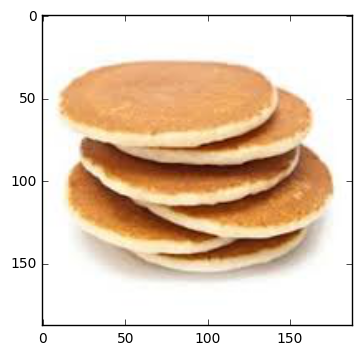

In [5]:
# Read a few images and display
im = plt.imread('./images/pancakes/images?q=tbn:ANd9GcQ1Jtg2V7Me2uybx1rqxDMV58Ow17JamorQ3GCrW5TUyT1tcr8EMg')
plt.imshow(im)

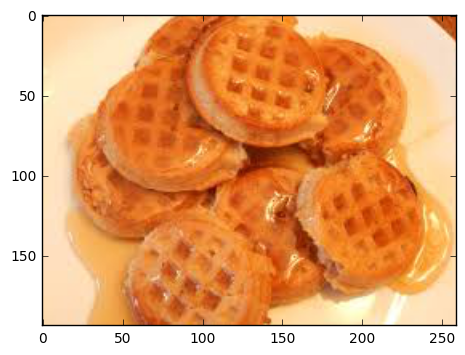

In [6]:
im = plt.imread('./images/waffles/images?q=tbn:ANd9GcQ-0-8U4TAw6fn4wDpj8V34AwbhkpK9SNKwobolotFjNcgspX8wmA')
plt.imshow(im)

In [7]:
# Model definition for VGG-16, 16-layer model from the paper:
# "Very Deep Convolutional Networks for Large-Scale Image Recognition"
# Original source: https://gist.github.com/ksimonyan/211839e770f7b538e2d8

# More pretrained models are available from
# https://github.com/Lasagne/Recipes/blob/master/modelzoo/
from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.nonlinearities import softmax
from lasagne.utils import floatX

def build_model():
    net = collections.OrderedDict()
    net['input'] = InputLayer((None, 3, 224, 224))
    net['conv1_1'] = ConvLayer(net['input'], 64, 3, pad=1)
    net['conv1_2'] = ConvLayer(net['conv1_1'], 64, 3, pad=1)
    net['pool1'] = PoolLayer(net['conv1_2'], 2)
    net['conv2_1'] = ConvLayer(net['pool1'], 128, 3, pad=1)
    net['conv2_2'] = ConvLayer(net['conv2_1'], 128, 3, pad=1)
    net['pool2'] = PoolLayer(net['conv2_2'], 2)
    net['conv3_1'] = ConvLayer(net['pool2'], 256, 3, pad=1)
    net['conv3_2'] = ConvLayer(net['conv3_1'], 256, 3, pad=1)
    net['conv3_3'] = ConvLayer(net['conv3_2'], 256, 3, pad=1)
    net['pool3'] = PoolLayer(net['conv3_3'], 2)
    net['conv4_1'] = ConvLayer(net['pool3'], 512, 3, pad=1)
    net['conv4_2'] = ConvLayer(net['conv4_1'], 512, 3, pad=1)
    net['conv4_3'] = ConvLayer(net['conv4_2'], 512, 3, pad=1)
    net['pool4'] = PoolLayer(net['conv4_3'], 2)
    net['conv5_1'] = ConvLayer(net['pool4'], 512, 3, pad=1)
    net['conv5_2'] = ConvLayer(net['conv5_1'], 512, 3, pad=1)
    net['conv5_3'] = ConvLayer(net['conv5_2'], 512, 3, pad=1)
    net['pool5'] = PoolLayer(net['conv5_3'], 2)
    net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
    net['fc7'] = DenseLayer(net['fc6'], num_units=4096)
    net['fc8'] = DenseLayer(net['fc7'], num_units=1000, nonlinearity=None)
    net['prob'] = NonlinearityLayer(net['fc8'], softmax)

    return net

In [8]:
# Download a pickle containing the pretrained weights
!wget -N https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg16.pkl

--2016-12-02 10:35:31--  https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg16.pkl
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.33.218
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.33.218|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘vgg16.pkl’ not modified on server. Omitting download.



In [9]:
# Load model weights and metadata
d = pickle.load(open('vgg16.pkl'))

In [10]:
# Build the network and fill with pretrained weights
net = build_model()
lasagne.layers.set_all_param_values(net['prob'], d['param values'])

In [11]:
# The network expects input in a particular format and size.
# We define a preprocessing function to load a file and apply the necessary transformations
IMAGE_MEAN = d['mean value'][:, np.newaxis, np.newaxis]

def prep_image(fn, ext='jpg'):
    im = plt.imread(fn, ext)

    # Resize so smallest dim = 256, preserving aspect ratio
    h, w, _ = im.shape
    if h < w:
        im = skimage.transform.resize(im, (256, w*256/h), preserve_range=True)
    else:
        im = skimage.transform.resize(im, (h*256/w, 256), preserve_range=True)

    # Central crop to 224x224
    h, w, _ = im.shape
    im = im[h//2-112:h//2+112, w//2-112:w//2+112]
    
    rawim = np.copy(im).astype('uint8')
    
    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # discard alpha channel if present
    im = im[:3]

    # Convert to BGR
    im = im[::-1, :, :]

    im = im - IMAGE_MEAN
    return rawim, floatX(im[np.newaxis])

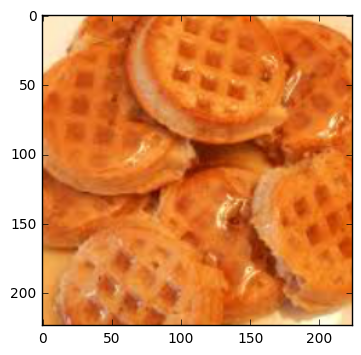

In [12]:
# Test preprocesing and show the cropped input
rawim, im = prep_image('./images/waffles/images?q=tbn:ANd9GcQ-0-8U4TAw6fn4wDpj8V34AwbhkpK9SNKwobolotFjNcgspX8wmA')
plt.imshow(rawim)

In [13]:
# Load and preprocess the entire dataset into numpy arrays
X = []
y = []

for cls in CLASSES:
    for fn in os.listdir('./images/{}'.format(cls)):
        _, im = prep_image('./images/{}/{}'.format(cls, fn))
        X.append(im)
        y.append(LABELS[cls])
        
X = np.concatenate(X)
y = np.array(y).astype('int32')

In [14]:
# Split into train, validation and test sets
train_ix, test_ix = sklearn.cross_validation.train_test_split(range(len(y)))
train_ix, val_ix = sklearn.cross_validation.train_test_split(range(len(train_ix)))

X_tr = X[train_ix]
y_tr = y[train_ix]

X_val = X[val_ix]
y_val = y[val_ix]

X_te = X[test_ix]
y_te = y[test_ix]

In [15]:
# We'll connect our output classifier to the last fully connected layer of the network
output_layer = DenseLayer(net['fc7'], num_units=len(CLASSES), nonlinearity=softmax)

In [16]:
# Define loss function and metrics, and get an updates dictionary
X_sym = T.tensor4()
y_sym = T.ivector()

prediction = lasagne.layers.get_output(output_layer, X_sym)
loss = lasagne.objectives.categorical_crossentropy(prediction, y_sym)
loss = loss.mean()

acc = T.mean(T.eq(T.argmax(prediction, axis=1), y_sym),
                      dtype=theano.config.floatX)

params = lasagne.layers.get_all_params(output_layer, trainable=True)
updates = lasagne.updates.nesterov_momentum(
        loss, params, learning_rate=0.0001, momentum=0.9)

In [17]:
# Compile functions for training, validation and prediction
train_fn = theano.function([X_sym, y_sym], loss, updates=updates)
val_fn = theano.function([X_sym, y_sym], [loss, acc])
pred_fn = theano.function([X_sym], prediction)

In [18]:
# generator splitting an iterable into chunks of maximum length N
def batches(iterable, N):
    chunk = []
    for item in iterable:
        chunk.append(item)
        if len(chunk) == N:
            yield chunk
            chunk = []
    if chunk:
        yield chunk

In [19]:
# We need a fairly small batch size to fit a large network like this in GPU memory
BATCH_SIZE = 16

In [20]:
def train_batch():
    ix = range(len(y_tr))
    np.random.shuffle(ix)
    ix = ix[:BATCH_SIZE]
    return train_fn(X_tr[ix], y_tr[ix])

def val_batch():
    ix = range(len(y_val))
    np.random.shuffle(ix)
    ix = ix[:BATCH_SIZE]
    return val_fn(X_val[ix], y_val[ix])

<IPython.core.display.Javascript object>


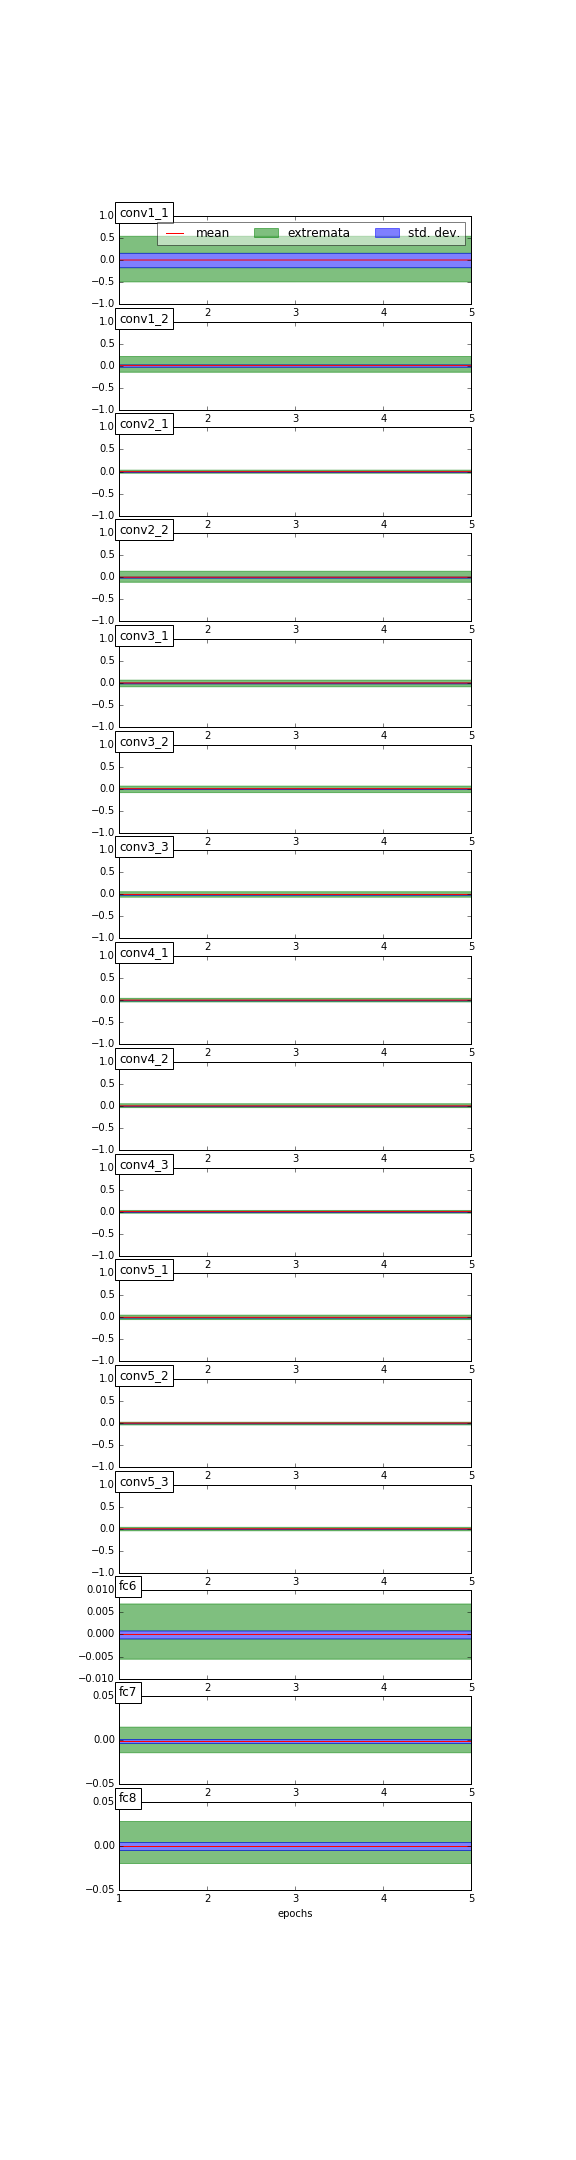

(0, 0.2191211047662994, 92.125984251968504)
(1, 0.22079759648465735, 91.338582724098146)
(2, 0.23093480176813019, 90.157480174162259)
(3, 0.22009633942030546, 90.157480314960623)
(4, 0.19777865655074908, 92.913385685973282)


<IPython.core.display.Javascript object>


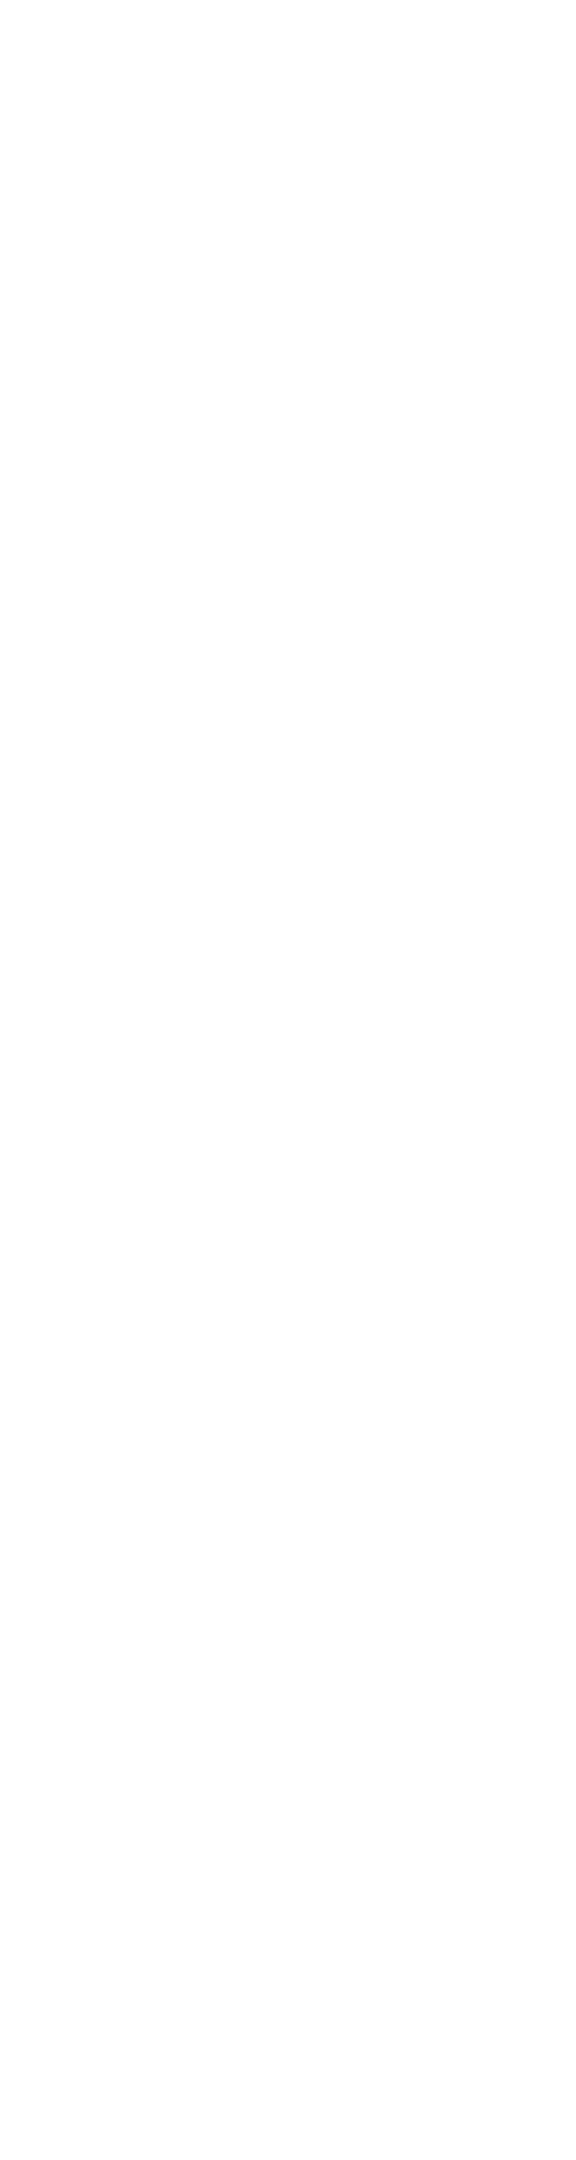

In [25]:
NO_EPOCHS = 5

%matplotlib notebook
f = plt.figure(figsize=(8,30))


custom_ranges = {'fc6':[-.01,.01], 'fc7':[-.05,.05], 'fc8':[-.05,.05]}
weight_supervisor = lasagne_visualizer.weight_supervisor(net, NO_EPOCHS, mode='currently_trainable',\
                                                         custom_weight_ranges=custom_ranges)
weight_supervisor.initialize_grid()

for epoch in range(NO_EPOCHS):
    for batch in range(25):
        loss = train_batch()

    ix = range(len(y_val))
    np.random.shuffle(ix)
    
    weight_supervisor.accumulate_weight_stats()
    weight_supervisor.live_plot()
    f.canvas.draw()
    
    loss_tot = 0.
    acc_tot = 0.
    for chunk in batches(ix, BATCH_SIZE):
        loss, acc = val_fn(X_val[chunk], y_val[chunk])
        loss_tot += loss * len(chunk)
        acc_tot += acc * len(chunk)

    loss_tot /= len(ix)
    acc_tot /= len(ix)
    print(epoch, loss_tot, acc_tot * 100)